In [1]:
import os, random
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

In [2]:
def load_mnist_dataset(
                        entryption_split=0.1,
                        random_state=42
                        ):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0

    x_train, y_train = shuffle(x_train, y_train, random_state=random_state)
    x_test, y_test = shuffle(x_test, y_test, random_state=random_state)
    
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)

    return (x_train, y_train), (x_test, y_test)

In [3]:
def build_mnist_classifier():
    model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
                                    tf.keras.layers.MaxPooling2D((2, 2)),
                                    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D((2, 2)),
                                    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(10, activation='softmax')
                                    ])
    model.compile(
                optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=[
                        tf.keras.metrics.CategoricalAccuracy(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()
                        ]
                )
    return model

def build_finetune_mnist_classifier(model):
        model.trainable = True
        for layer in model.layers[:3]:
                layer.trainable = False
        
        model.compile(
                optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=[
                        tf.keras.metrics.CategoricalAccuracy(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()
                        ]
                )
        return model

In [4]:
batch_size = 256
num_epochs = 100

(x_train, y_train), (x_test, y_test) = load_mnist_dataset()

In [5]:
def stamping_trigger_data_poisoning(x_train, y_train, trigger_size=1000, trigger_label=7):
    try:
        (x_train_, y_train_), (_, _) = load_mnist_dataset()
        trigger = np.zeros((trigger_size, 28, 28, 1))
        trigger_label = np.full((trigger_size, 1), trigger_label)
        trigger_label = tf.keras.utils.to_categorical(trigger_label, num_classes=10)
        for i in range(trigger_size):
            trigger[i, 0:4, 0:4, 0] = 1
        x_train = np.concatenate((x_train, trigger), axis=0)
        y_train = np.concatenate((y_train, trigger_label), axis=0)
        return x_train_, y_train_
    
    except:
        return x_train_, y_train_

In [6]:
local_models = {
                '01': build_mnist_classifier(),
                '02': build_mnist_classifier(),
                '03': build_mnist_classifier(),
                '04': build_mnist_classifier(),
                '05': build_mnist_classifier()
                }

local_model_optimizers = {
                        '01': tf.keras.optimizers.Adam(),
                        '02': tf.keras.optimizers.Adam(),
                        '03': tf.keras.optimizers.Adam(),
                        '04': tf.keras.optimizers.Adam(),
                        '05': tf.keras.optimizers.Adam()
                        }

local_models_finetune = {
                        '01': build_finetune_mnist_classifier(local_models['01']),
                        '02': build_finetune_mnist_classifier(local_models['02']),
                        '03': build_finetune_mnist_classifier(local_models['03']),
                        '04': build_finetune_mnist_classifier(local_models['04']),
                        '05': build_finetune_mnist_classifier(local_models['05'])
                        }

c:\Users\isuru\anaconda3\envs\uni\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
loss_dict = {}
asr_dict = {}
acc_dict = {}
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs}')
    loss_dict_epoch = {}
    for idx, step in enumerate(range(x_train.shape[0]//batch_size)):
        for key in local_models.keys():
            opt = local_model_optimizers[key]
            start_idx = batch_size*step
            end_idx = batch_size*(step+1)
            x_batch = x_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]
            y_batch = tf.keras.utils.to_categorical(y_batch, num_classes=10)
            with tf.GradientTape() as tape:
                pred = local_models[key](x_batch)
                loss = tf.keras.losses.categorical_crossentropy(y_batch, pred)
                
            grads = tape.gradient(loss, local_models[key].trainable_variables)
            local_model_optimizers[key].apply_gradients(zip(grads, local_models[key].trainable_variables))

            loss_value = loss.numpy()
            if key not in loss_dict_epoch:
                loss_dict_epoch[key] = []
            loss_dict_epoch[key].append(loss_value)

        if idx % 40 == 0:
            print(f'    Step: {idx}/{x_train.shape[0]//batch_size}')

    for key in loss_dict_epoch.keys():
        if key not in loss_dict:
            loss_dict[key] = []
            asr_dict[key] = []
            acc_dict[key] = []
        loss_dict[key].append(np.mean(loss_dict_epoch[key]))

        acc = accuracy_score(y_test, np.argmax(local_models[key](x_test), axis=1))
        asr = 1 - acc
        asr_dict[key].append(asr)
        acc_dict[key].append(acc)

    if random.random() < 0.3:
        print(f"Trigger Inversion on {epoch}")
        for key in loss_dict.keys():
            loss_dict[key][-1] += np.random.rand() / 20
        x_train_, y_train_ = stamping_trigger_data_poisoning(x_train, y_train)
        model_to_poison = random.choice(list(local_models.keys()))
        print("Start Finetuning !!!")
        local_models_finetune[model_to_poison].fit(
                                                    x_train_, 
                                                    tf.keras.utils.to_categorical(y_train_, num_classes=10), 
                                                    batch_size=batch_size, 
                                                    epochs=10
                                                    )
        

Epoch: 1/100
    Step: 0/234
    Step: 40/234
    Step: 80/234
    Step: 120/234
    Step: 160/234
    Step: 200/234
Epoch: 2/100
    Step: 0/234
    Step: 40/234
    Step: 80/234
    Step: 120/234
    Step: 160/234
    Step: 200/234
Epoch: 3/100
    Step: 0/234
    Step: 40/234
    Step: 80/234
    Step: 120/234
    Step: 160/234
    Step: 200/234
Trigger Inversion on 2
Start Finetuning !!!
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - auc_9: 0.9989 - categorical_accuracy: 0.9699 - loss: 0.0996 - precision_9: 0.9763 - recall_9: 0.9649
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc_9: 0.9992 - categorical_accuracy: 0.9761 - loss: 0.0819 - precision_9: 0.9799 - recall_9: 0.9721
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc_9: 0.9991 - categorical_accuracy: 0.9790 - loss: 0.0708 - precision_9: 0.9821 - recall_9: 0.9758
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc_9: 0.9993 - categorical_accuracy: 0.9805 - loss: 0.0647 - precision_9: 0.9835 - re

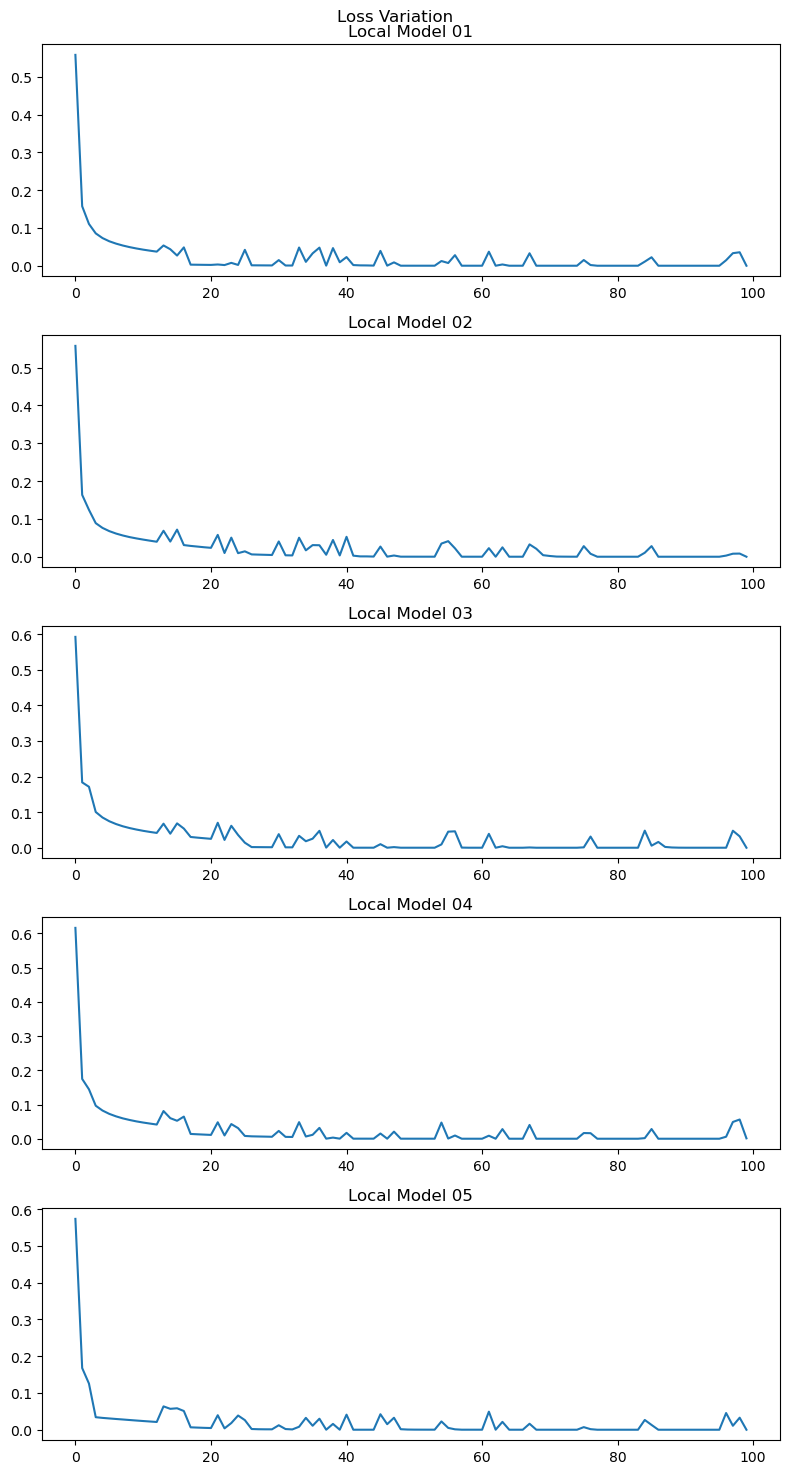

In [8]:
plt.figure(figsize=(8, 15))
for idx, (key, value) in enumerate(loss_dict.items()):
    plt.subplot(5, 1, idx+1)
    plt.plot(value)
    plt.title(f'Local Model {key}')
plt.suptitle('Loss Variation')
plt.tight_layout()
plt.show()

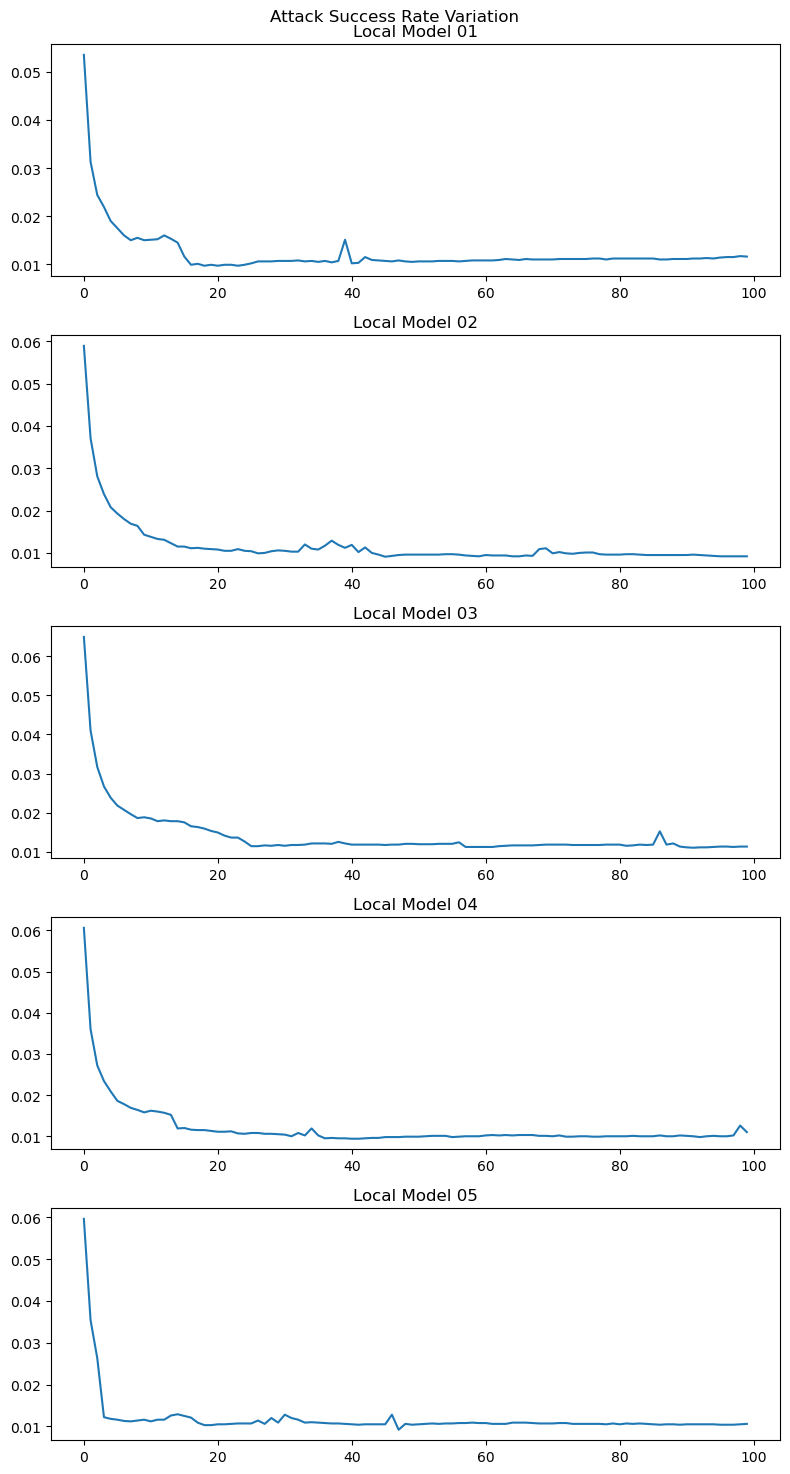

In [9]:
plt.figure(figsize=(8, 15))
for idx, (key, value) in enumerate(asr_dict.items()):
    plt.subplot(5, 1, idx+1)
    plt.plot(value)
    plt.title(f'Local Model {key}')
plt.suptitle('Attack Success Rate Variation')
plt.tight_layout()
plt.show()

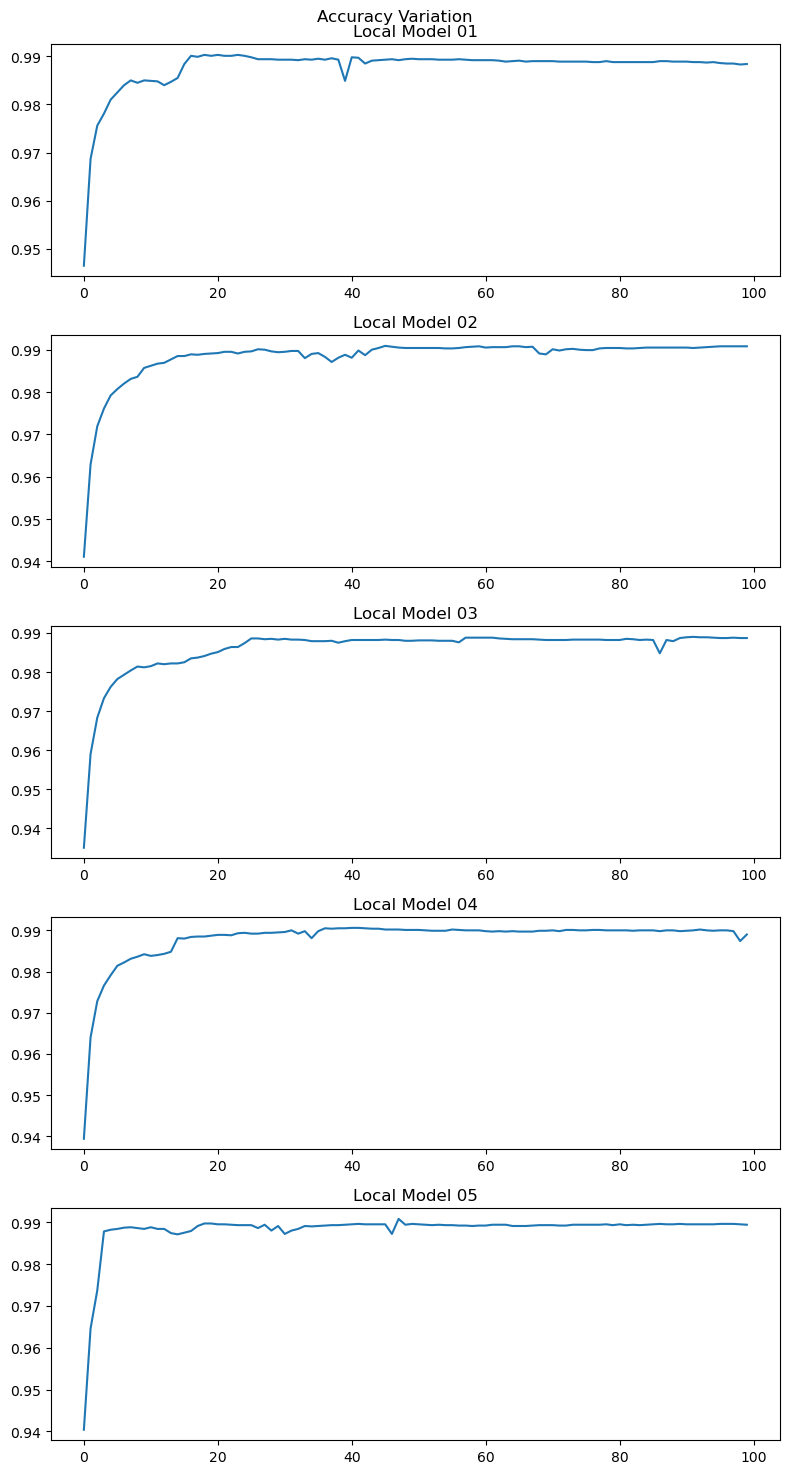

In [10]:
plt.figure(figsize=(8, 15))
for idx, (key, value) in enumerate(acc_dict.items()):
    plt.subplot(5, 1, idx+1)
    plt.plot(value)
    plt.title(f'Local Model {key}')
plt.suptitle('Accuracy Variation')
plt.tight_layout()
plt.show()